In [9]:
from evalml.pipelines import BinaryClassificationPipeline
from sklearn import datasets
import time
from evalml.tests.automl_tests.test_dask_engine import test_automl_data
from evalml.automl.engine.dask_engine import DaskEngine
from evalml.automl.engine.sequential_engine import SequentialEngine
from dask.distributed import Client, progress
import pandas as pd

In [11]:
# Get some information about the local cluster that's made
client = Client()
client.close()

client

Port 8787 is already in use.
Perhaps you already have a cluster running?
Hosting the HTTP server on port 53707 instead


Client Scheduler: tcp://127.0.0.1:53708 Dashboard: http://127.0.0.1:53707/status,Cluster Workers: 0 Cores: 0 Memory: 0 B


In [3]:
def do_parallel_1(func, pipelines, X, y):
    """ A method of performing pipeline evaluation in parallel"""
    futures = []
    for pipeline in pipelines:
        futures.append(func(X=X, y=y, automl_data=automl_data, pipeline=pipeline))
    results = [f.get_result() for f in futures]
    return results

def time_parallel(func, pipelines, X, y, client):
    parallel_time_start = time.time()
    X, y = client.scatter([X,y])
    do_parallel_1(func, pipelines, X, y)
    parallel_time_taken = time.time()-parallel_time_start
    return parallel_time_taken, results

In [4]:
def time_sequential(func, pipelines, X, y):
    sequential_time_start = time.time()
    futures = []
    for pipeline in pipelines:
        futures.append(func(X=X, y=y, automl_data=automl_data, pipeline=pipeline))
    results = [f.get_result() for f in futures]
    sequential_time_taken = time.time()-sequential_time_start
    return sequential_time_taken, results                                                                      

In [7]:
automl_data = test_automl_data()

# Instantiate client
client = Client()

class TestBinaryClassificationPipeline(BinaryClassificationPipeline):
    component_graph = ["Logistic Regression Classifier"]
    
num_pipelines = 16
pipelines = []
for i in range(num_pipelines):
    pipelines.append(TestBinaryClassificationPipeline({}))
    
seq_times = []
par_times = []
speed_up = []
num_samples= [10, 40, 160, 640, 2560, 5120, 10240, 20480, 40960, 81920]

for n_s in num_samples:
    X, y = datasets.make_classification(n_samples=n_s, n_features=200,
                                    n_informative=2, n_redundant=2, random_state=0)

    engine = DaskEngine(client)
    parallel_time, parallel_results = time_parallel(engine.submit_training_job, pipelines, X, y, client)
    par_times.append(parallel_time)

    engine = SequentialEngine()
    sequential_time, sequential_results = time_sequential(engine.submit_training_job, pipelines, X, y)
    seq_times.append(sequential_time)
    speed_up.append(sequential_time/parallel_time)
    
    print("Num_samples:", n_s, "Sequential Time: ", sequential_time, "Parallel Time:", parallel_time, 
          "Speedup:", speed_up[-1])
    
# Close client
client.close()

Port 8787 is already in use.
Perhaps you already have a cluster running?
Hosting the HTTP server on port 53478 instead


Num_samples: 10 Sequential Time:  5.634020090103149 Parallel Time: 5.487677335739136 Speedup: 1.026667521687352
Num_samples: 40 Sequential Time:  4.191630840301514 Parallel Time: 1.5044269561767578 Speedup: 2.7861976436222746
Num_samples: 160 Sequential Time:  3.287222146987915 Parallel Time: 1.5292212963104248 Speedup: 2.149605263096352
Num_samples: 640 Sequential Time:  2.722060203552246 Parallel Time: 1.0425269603729248 Speedup: 2.6110213999439704
Num_samples: 2560 Sequential Time:  12.575285911560059 Parallel Time: 1.3072710037231445 Speedup: 9.619494256160575
Num_samples: 5120 Sequential Time:  13.48166298866272 Parallel Time: 1.3592989444732666 Speedup: 9.918100093785414
Num_samples: 10240 Sequential Time:  15.500561714172363 Parallel Time: 1.8754370212554932 Speedup: 8.265039848576553
Num_samples: 20480 Sequential Time:  20.93588900566101 Parallel Time: 3.755613088607788 Speedup: 5.574559602310359
Num_samples: 40960 Sequential Time:  28.772375106811523 Parallel Time: 7.698699951

Text(0, 0.5, 'Wall Clock Time (s)')

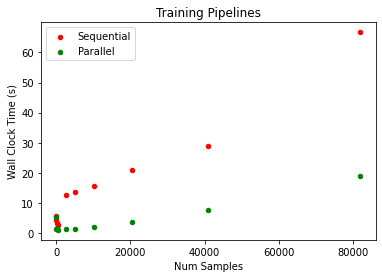

In [10]:
df = pd.DataFrame()
df["Num Samples"] = num_samples
df["Sequential Time"] = seq_times
df["Parallel Time"] = par_times

ax = df.plot(kind="scatter", x="Num Samples", y = "Sequential Time", color="r")
df.plot(kind="scatter", x="Num Samples", y = "Parallel Time", color="g", ax=ax)
ax.legend(["Sequential", "Parallel"])
ax.set_title("Training Pipelines")
ax.set_xlabel("Num Samples")
ax.set_ylabel("Wall Clock Time (s)")

In [ ]:
for n_s in num_samples:
    X, y = datasets.make_classification(n_samples=n_s, n_features=200,
                                    n_informative=2, n_redundant=2, random_state=0)

    engine = DaskEngine(client)
    parallel_time, parallel_results = time_parallel(engine.submit_training_job, pipelines, X, y, client)
    par_times.append(parallel_time)

    engine = SequentialEngine()
    sequential_time, sequential_results = time_sequential(engine.submit_training_job, pipelines, X, y)
    seq_times.append(sequential_time)
    speed_up.append(sequential_time/parallel_time)
    
    print("Num_samples:", n_s, "Sequential Time: ", sequential_time, "Parallel Time:", parallel_time, 
          "Speedup:", speed_up[-1])
    

In [ ]:
# without scatter Sequential Time:  5.393399953842163 Parallel Time: 3.6696488857269287

# 40000 samples, 200 n_features
# Without scatter Sequential Time:  27.692340850830078 Parallel Time: 11.069131135940552
# With scatter/broadcast = False Sequential Time: 27.925297737121582 Parallel Time: 11.293490886688232
# With scatter/broadcast = True Sequential Time:  27.503095149993896 Parallel Time: 11.242128133773804

# 40000 samples, 2000 n_features, n_pipelines = 16
# Without scatter Sequential Time:  122.6994891166687 Parallel Time: 119.01962494850159
# With scatter/broadcast = False Sequential Time:  123.0830340385437 Parallel Time: 90.91308689117432
# With scatter/broadcast = True Sequential Time: 123.36094689369202 Parallel Time: 102.01213908195496



In [ ]:
\\\\\\\\\